# Прогноз оттока клиентов из фитнес-клуба 

### Описание проекта:

Сеть фитнес-центров разрабатывает стратегию взаимодействия с пользователями на основе аналитических данных. Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Чтобы бороться с оттоком, отдел по работе с клиентами фитнес-центра перевёл в электронный вид множество анкет пользователей.

### Задачи:
* научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
* сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* проанализировать основные признаки, наиболее сильно влияющие на отток;
* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами

## Загрузка и предобработка данных

In [1]:
# Импорт библиотек:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import warnings
import plotly.express as px
from plotly import graph_objects as go
import plotly.io as pio
pio.renderers
warnings.filterwarnings('ignore')

In [2]:
local_path = 'C://Users//lenovo//Documents//Y.Praktikum//datasets//'
gym_churn = pd.read_csv(local_path + 'gym_churn.csv')
gym_churn.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

#### Описание данных:

* 'Churn' — факт оттока в текущем месяце;
* 'gender' — пол
* 'Near_Location' — проживание или работа в районе, где находится фитнес-центр
* 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
* Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
* 'Phone' — наличие контактного телефона
* 'Age' — возраст
* 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах)
* 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
* 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)
* 'Group_visits' — факт посещения групповых занятий
* 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента
* 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц
* 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

In [4]:
# преобразуем названия колонок к нижнему регистру:
gym_churn.columns = gym_churn.columns.str.lower()

## Исследовательский анализ данных (EDA)

In [5]:
# взглянем на датасет подробнее
gym_churn.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Примерно равное распределение по гендеру. В целом клиенты клуба работают или живут рядом, оставили контактный телефон, средний возраст - 29 лет, пришли три - три с половиной месяца назад, причем чуть меньше половины - по промо-акции от компании-партнера. Примерно треть пришла по промо-акции от друга. Можем заключить, что подобные промо вполне эффективны.
В среднем период договора составляет 4.6 месяцев при том, что большинство клиентов берут абонемент на 1 месяц. Посещают клуб в среднем 1-2 раза в неделю.

Также, исходя из данных можем заключить, что есть самый популярный тип абонемента - на 1 месяц. Плюс предусмотрены варианты 6 и 12 месяцев.

In [6]:
# посмотрим средние значения по группам оставшихся и ушедших клиентов:
mean_by_churn = gym_churn.groupby('churn').mean()
mean_by_churn

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


In [7]:
nonbinary_columns = ['contract_period', 'age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']
binary_columns = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']
churn_0 = gym_churn.loc[gym_churn['churn']==0]
churn_1 = gym_churn.loc[gym_churn['churn']==1]

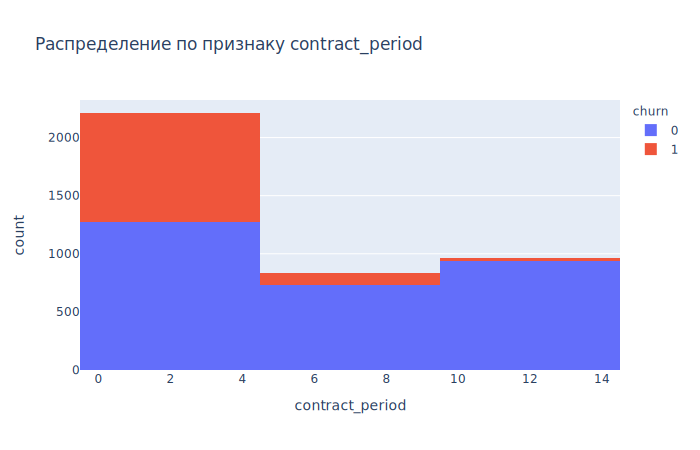

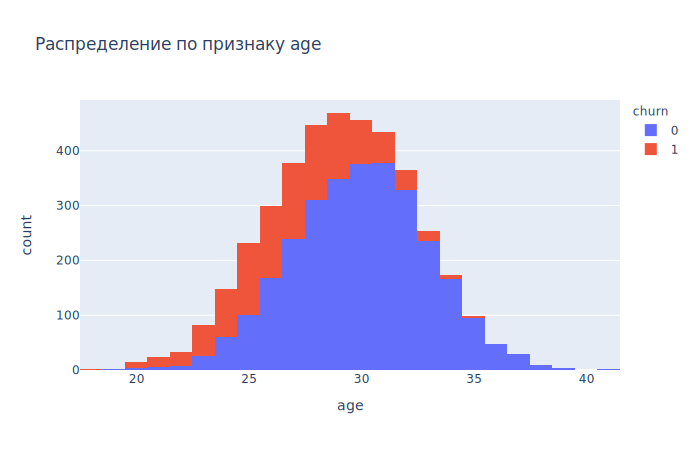

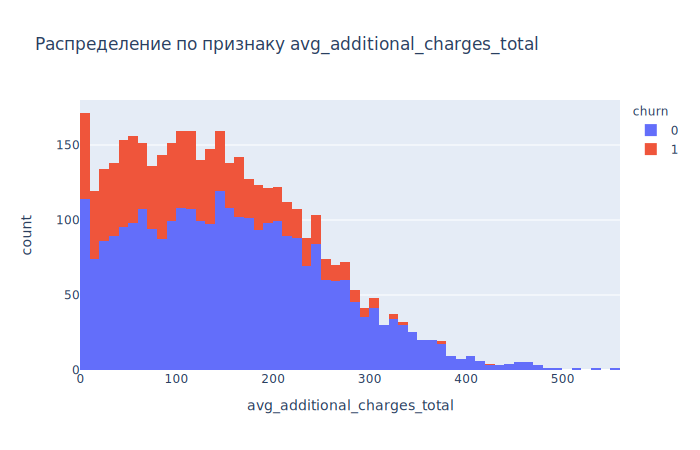

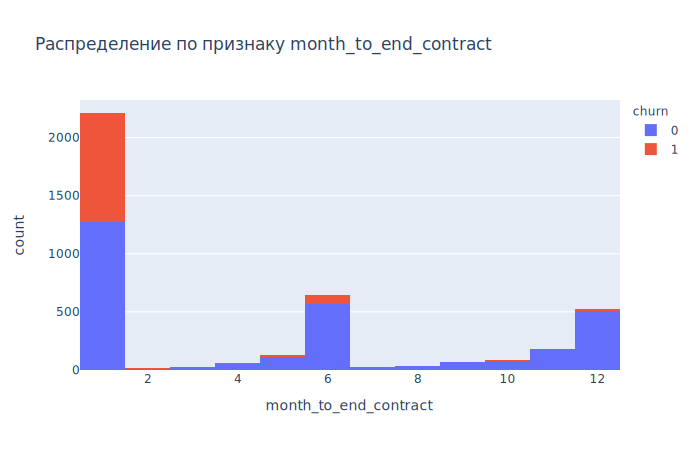

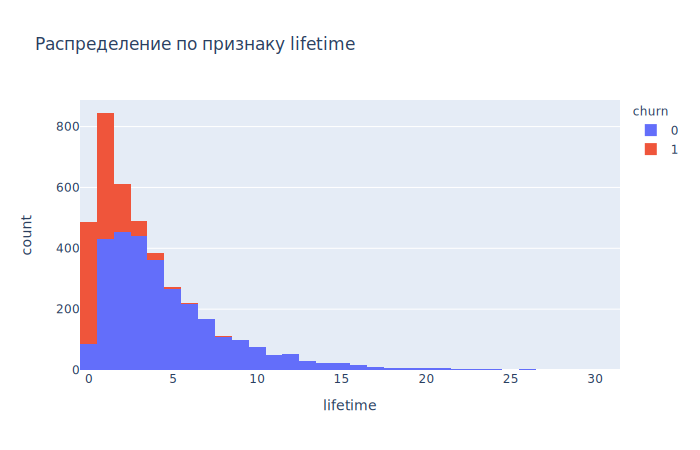

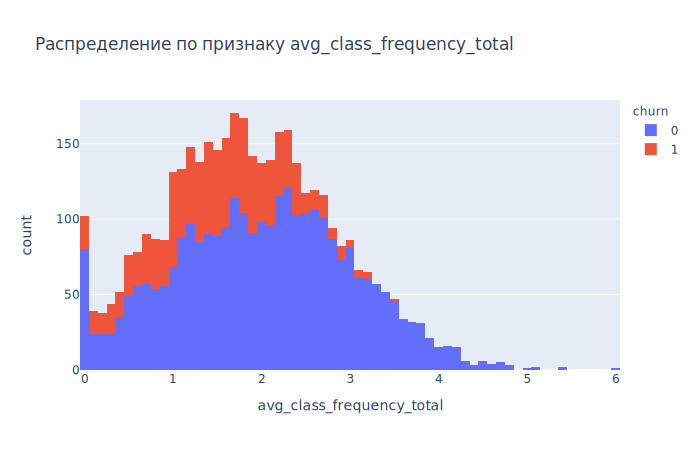

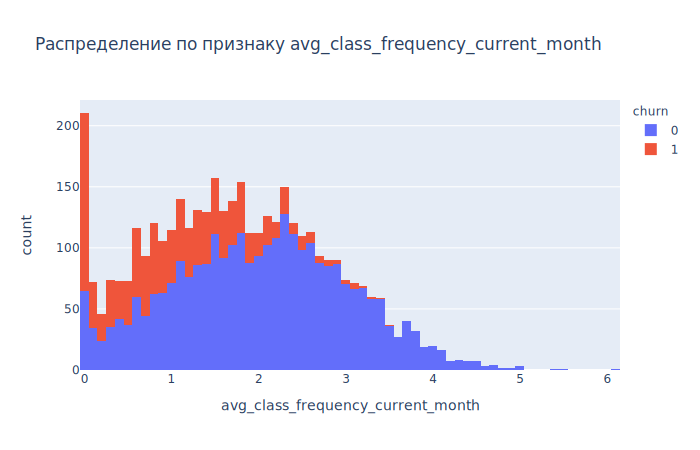

In [8]:
# распределение по небинарным признакам
for col in nonbinary_columns:
    fig = px.histogram(gym_churn, x=col, color='churn', title='Распределение по признаку {}'.format(col))
    fig.show(renderer="svg")

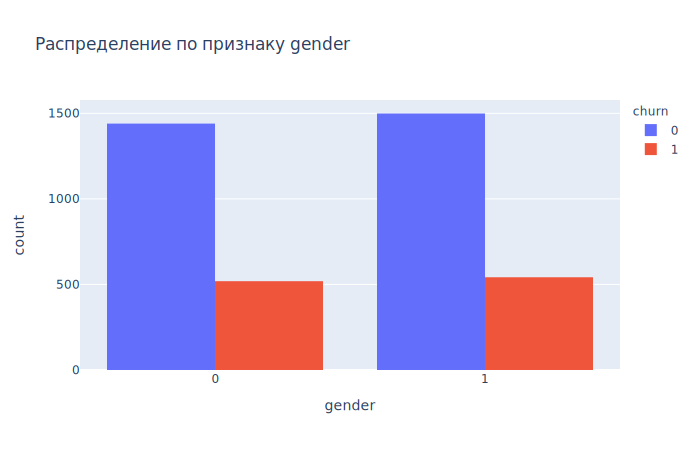

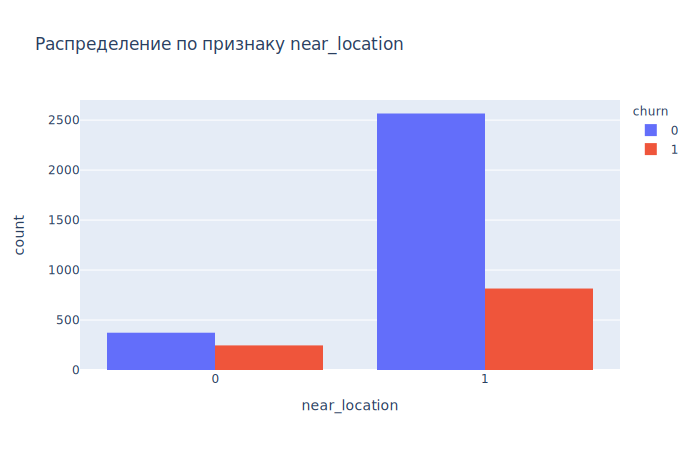

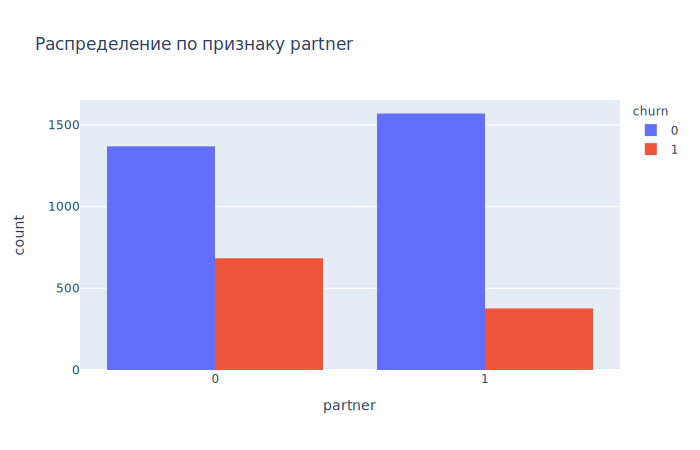

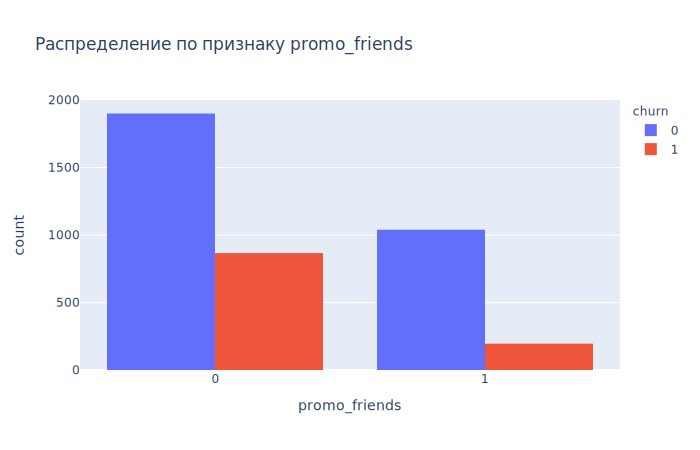

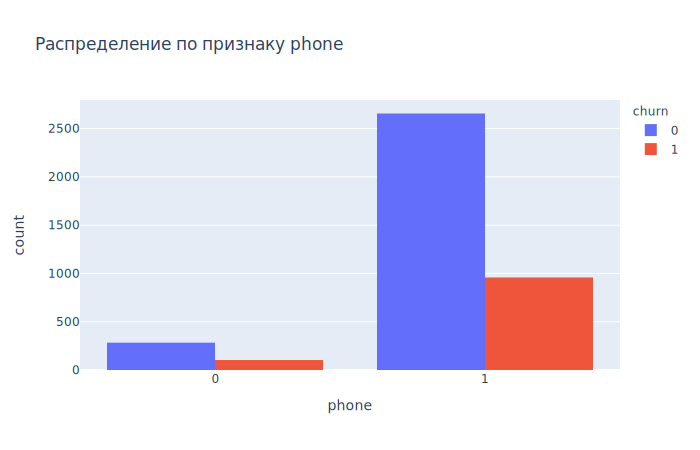

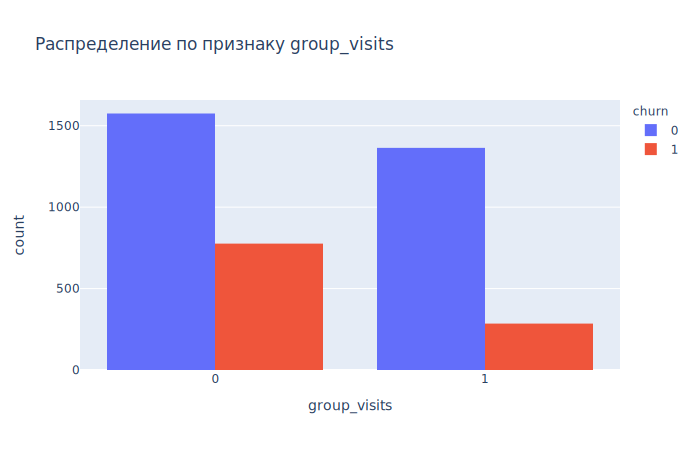

In [9]:
# распределение кластеров по бинарным признакам
for col in binary_columns:
    fig = px.histogram(gym_churn, x=col, barmode='group', color='churn', title='Распределение по признаку {}'.format(col))
    fig.show(renderer="svg")

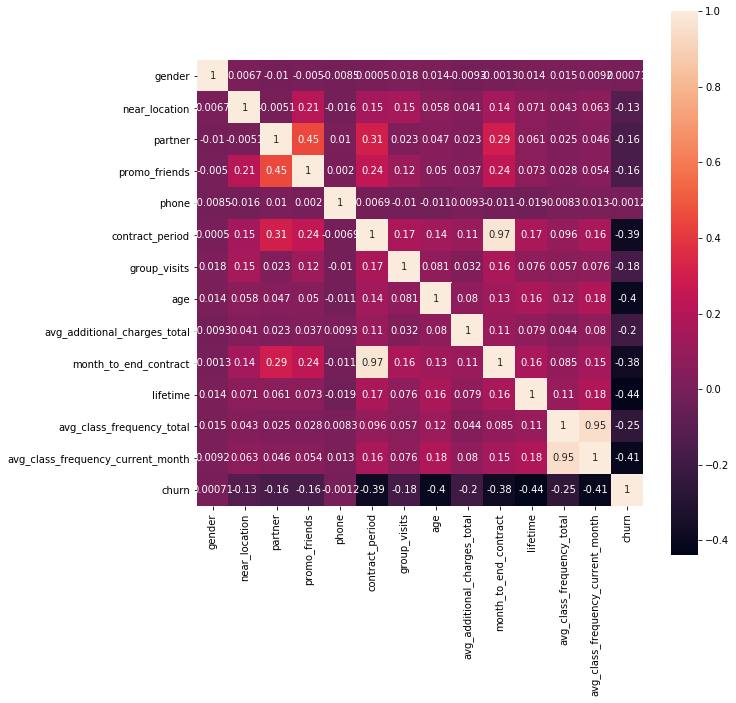

In [10]:
cm = gym_churn.corr() 
sns.set_palette('cubehelix', 3) 
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot = True, square=True);

#### Выводы:

1. Среди тех, кто ушел, по полу разницы нет
2. Те, кто живут или работают рядом, уходят меньше
3. Примерно в равной степени уходят те, кто пришел от партнерской компании и самостоятельно (у сотрудников партнерских компаний уровень оттока лишь немного ниже)
4. Текущие клиенты чаще занимаются в группах
5. Оставил клиент телефон или нет, никак ее коррелирует с тем, останется он или нет (впрочем, уходящие оставляют телефон чуть реже)
6. Уходят чаще всего клиенты, которые пришли недавно плюс их абонемент истекает примерно через месяц
7. Те, кто пришел по приглашению от друга, уходят меньше
8. По возрасту в зоне риска люди от 25 до 32 лет (они уходят чаще, но их и в целом больше)
9. Наиболее сильно с churn кореллируют признаки частота посещения в последнем месяце, lifetime, время до конца контракта и возраст
10. Корреляция оттока по таким параметрам, как возраст, проживание или работа поблизости или привлечение клиента в рамках промо (с другом или партнерской компанией) отсутствует.


## Модель прогнозирования оттока пользователей

In [11]:
# импорт библиотек
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [12]:
# разобьем датасет на обучающую и валидационную выборки
X = gym_churn.drop('churn', axis = 1)
y = gym_churn['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

#### Обучение логистической регрессией:

In [13]:
# зададим алгоритм для модели
model = LogisticRegression()

scaler = StandardScaler()
scaler.fit(X_train)
 
# стабилизируем данные
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# обучим модель
model.fit(X_train_st, y_train)

# сделаем прогнозы
predictions = model.predict(X_test_st)
#probabilities = model.predict_proba(X_test_st)[:,1]

# выведем метрики
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
#print('F1: {:.2f}'.format(f1_score(y_test, predictions)))

Accuracy: 0.93
Precision: 0.88
Recall: 0.83


#### Обучение Random Forest:

In [14]:
# зададим алгоритм для модели логистической регрессии
for_model = RandomForestClassifier()

# обучим модель решающего дерева
for_model.fit(X_train_st, y_train)

# воспользуемся обученной моделью, чтобы сделать прогнозы
for_predictions = for_model.predict(X_test_st)
#for_probabilities = for_model.predict_proba(X_test_st)[:,1]

# выведем метрики
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, for_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, for_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, for_predictions)))
#print('F1: {:.2f}'.format(f1_score(y_test, for_predictions)))

Accuracy: 0.93
Precision: 0.90
Recall: 0.83


Метрика Recall нам важнее, чем точность. Важно не упустить ни одного клиента, который соберется уйти, и вовремя провести с ним работу. Так что выберем логистическую регрессию в качестве модели.

## Кластеризация пользователей

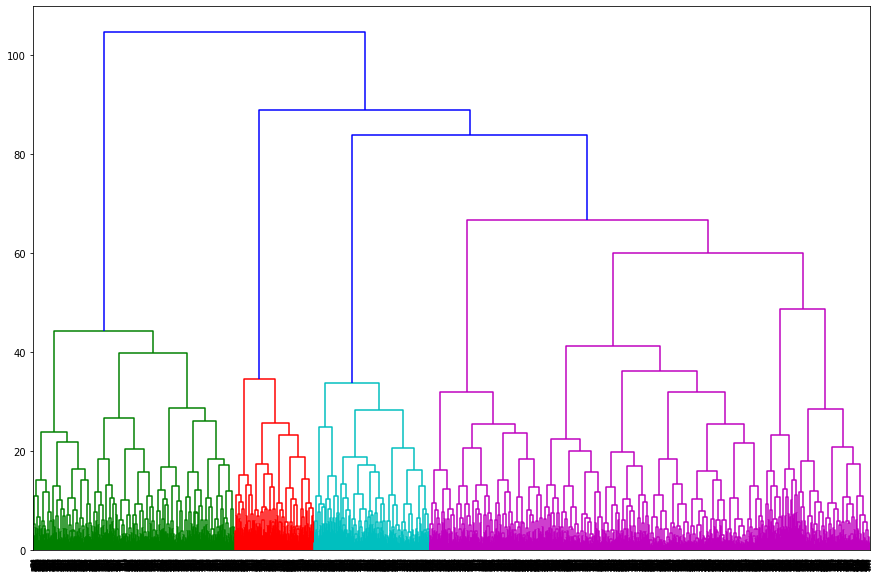

In [15]:
from scipy.cluster.hierarchy import dendrogram, linkage
sc = StandardScaler() 
X_sc = sc.fit_transform(X)
linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show()

In [16]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters = 5) # задаём число кластеров 5
labels = km.fit_predict(X_sc) # применяем алгоритм к данным и формируем вектор кластеров

# сохраняем метки кластера в поле датасета
gym_churn['cluster_labels'] = labels

gym_churn.groupby(['cluster_labels']).mean() #смотрим на средние значения признаков по кластерам

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_labels,,,,,,,,,,,,,,
0,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,1.723967,0.266839
1,0.483254,0.722488,0.295853,0.012759,1.0,1.914673,0.275120,28.121212,129.637399,1.821372,2.204147,1.250734,0.998003,0.563796
2,0.495987,0.948636,0.817014,0.998395,1.0,3.025682,0.436597,29.070626,140.810636,2.834671,3.722311,1.713221,1.605656,0.258427
3,0.563867,0.849252,0.278481,0.070196,1.0,2.680092,0.451093,30.041427,161.065661,2.479862,4.838895,2.793518,2.785397,0.081703
4,0.500000,0.936636,0.740783,0.480415,1.0,11.827189,0.547235,29.892857,163.426463,10.785714,4.711982,2.001185,1.993578,0.021889


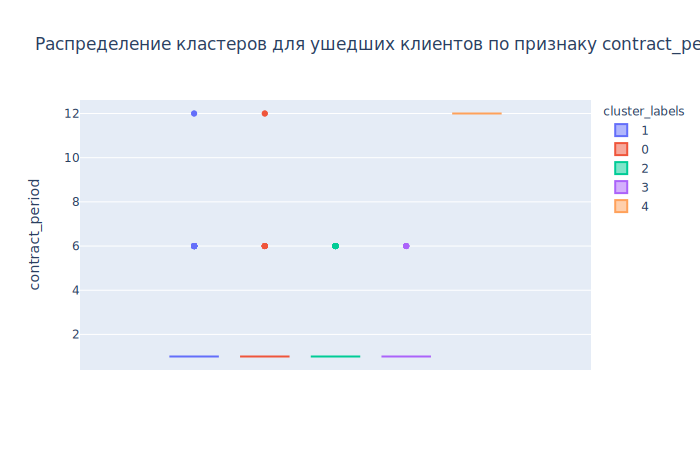

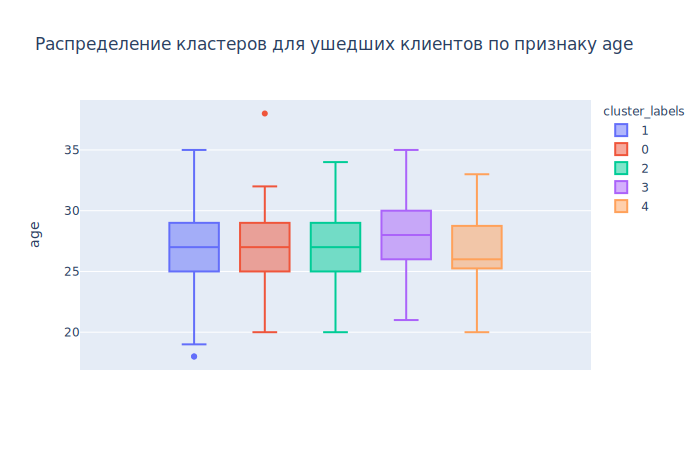

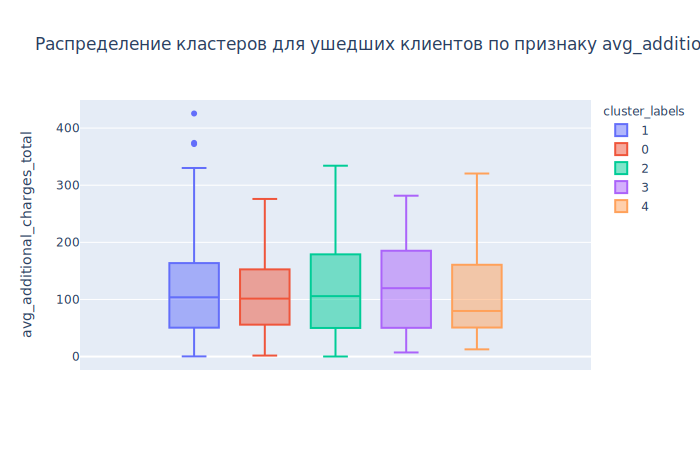

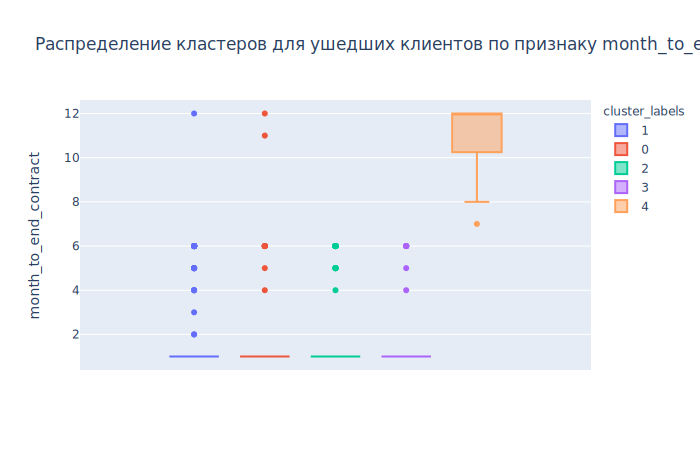

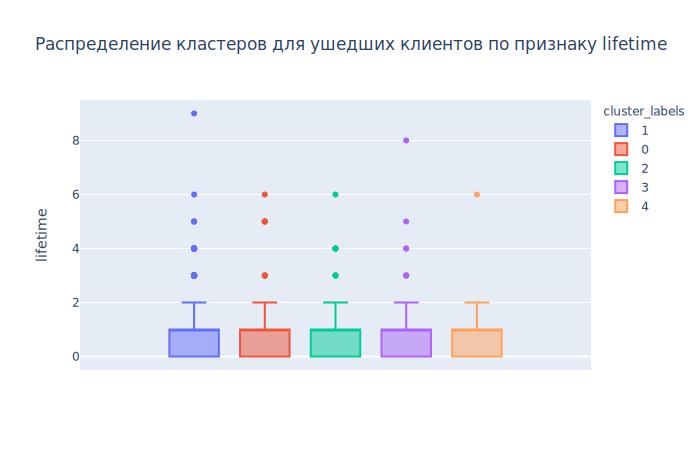

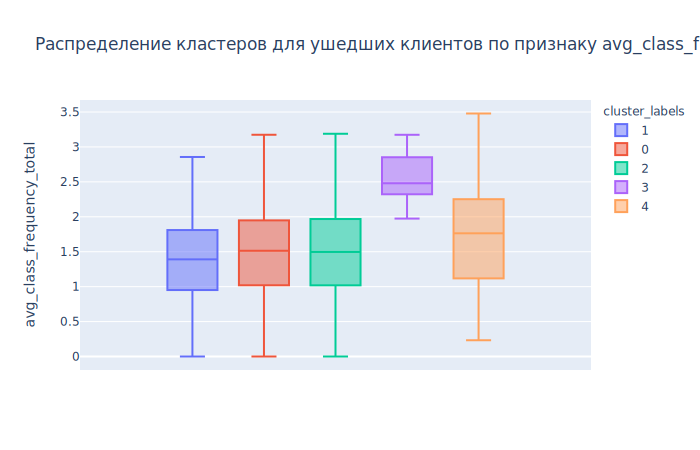

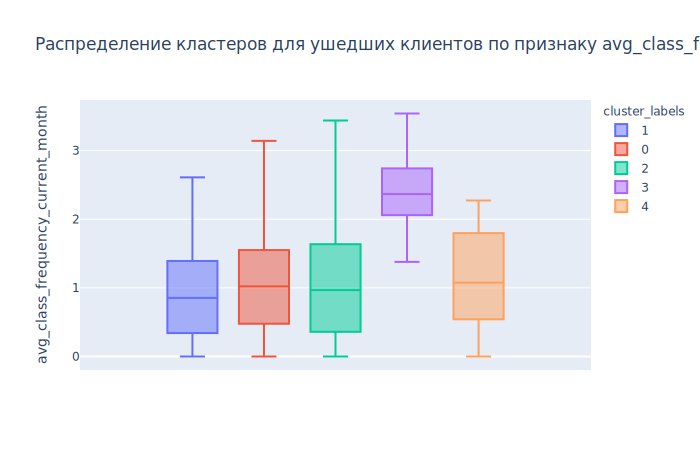

In [17]:
# распределение кластеров по небинарным признакам для ушедших клиентов
for col in nonbinary_columns:
    fig = px.box(gym_churn.query('churn==1'), y=col, color='cluster_labels', title='Распределение кластеров для ушедших клиентов по признаку {}'.format(col))
    fig.show(renderer="svg")

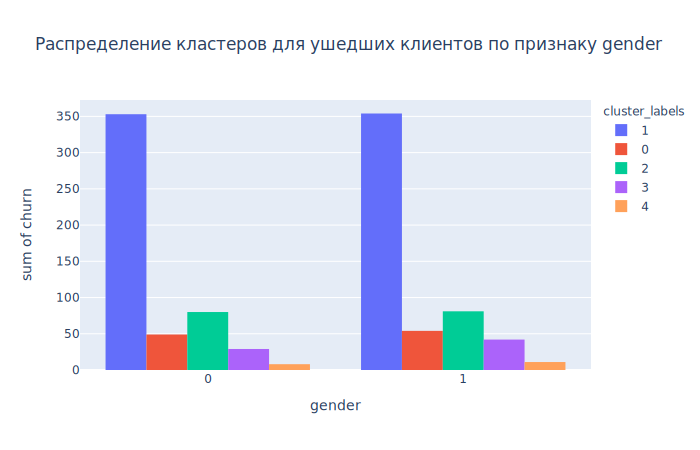

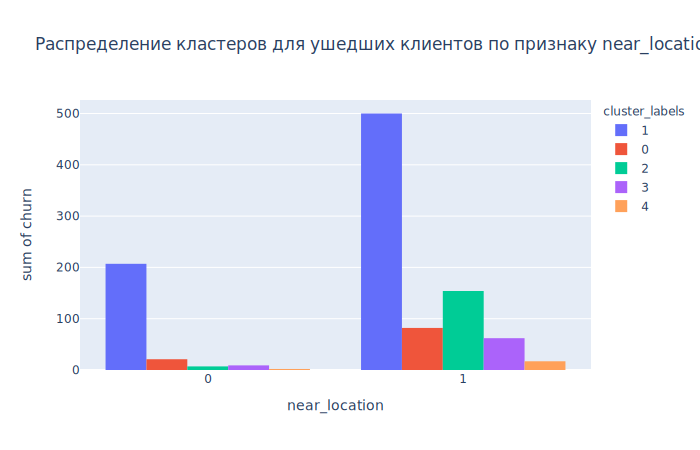

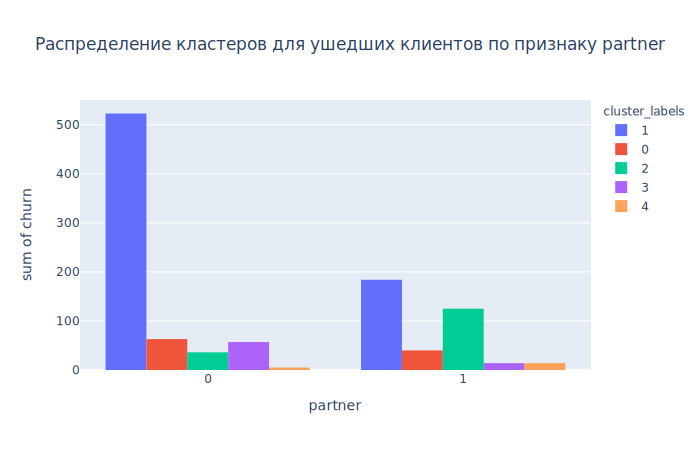

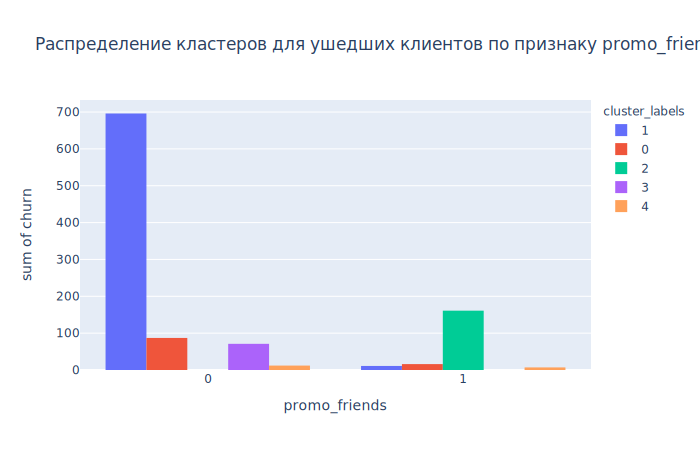

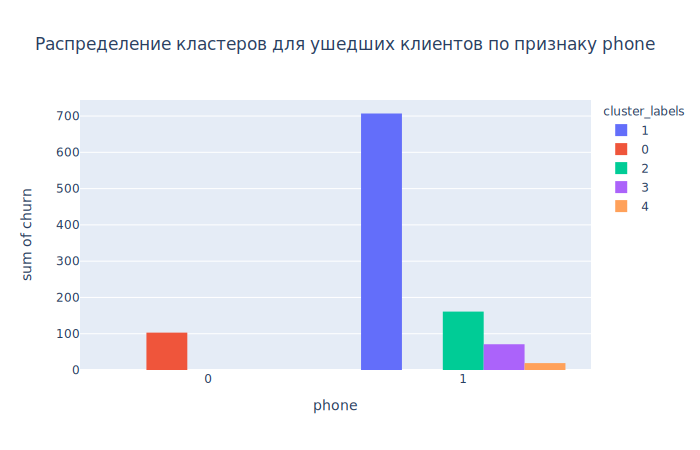

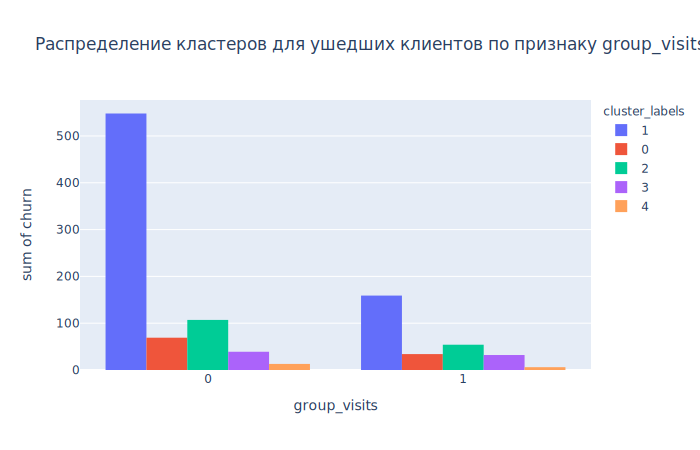

In [18]:
# распределение кластеров по бинарным признакам для ушедших клиентов

for col in binary_columns:
    fig = px.histogram(gym_churn.query('churn==1'), x=col, y='churn', barmode='group', color='cluster_labels',
                       title='Распределение кластеров для ушедших клиентов по признаку {}'.format(col))
    fig.show(renderer="svg")

#### Выводы:

Можно разбить клиентов на следующие условные группы:


1. Кластер "Мимокрокодилы":
    * Живут или работают рядом. Пришли недавно и абонемент скоро закончится. Вероятно пришли попробовать, а там видно будет. Либо занимаются эпизодически, когда решат начать новую жизнь с понедльника. Берут абонемент на месяц, уходят, затем возможно история повторяется. Значительный отток.


2. Кластер "Прекрасное далёко":
    * Живут и работают далеко. Перестают ходить, так как это по всей видимости просто неудобно. Значительный отток.


3. Кластер "Не звони мне":
    * Эти ребята не оставляют телефоны.Уровень оттока в группе не критичный, но все еще весомый. Видимо менеджеры не могут с ними работать и делать новые предложения.


4. Кластер "Активные ребята":
    * Срок договоров не такой большой, как скажем, у следующего кластера - в среднем до полугода. Но эти клиенты действительно горят спортом. Ходят значительно чаще прочих. Живут или работают рядом. Отток крайне мал. 


5. Кластер "Пока смерть не разлучит нас":
    * Тут вообще все здорово. Клиенты с нами давно, договора у них на год (или около того), на занятия ходят активно. Приходят часто по рекомендации друга или работают в компании-партрнере. Отток крайне мал.


## Вывод

В рамках работы:

* был проведен исследовательский анализ данных, в ходе которого мы выявили признаки, наиболее сильно влияющие на отток пользователей (это наличие телефона клиента, работа или проживание рядом с клубом, срок договора и период нахождения клиента в клубе)
* Были сформированы типичные портреты пользователей в рамках формирования 5 кластеров с помощью K-Means. В главной группе риска клиенты, которые самостоятельно (без участия друга или компании-партнера) пришли попробовать фитнес-клуб на короткий период. 
* Была обучена оптимальная модель (логистическая регрессия), которая сможет прогнозировать вероятность оттока для каждого клиента.

#### Рекомендации:

* Для уменьшения оттока клиентов сосредоточить внимание и детальнее работать с клиентам кластера "Мимокрокодилы". А именно, стараться заинтересовать их выгодными предложениями и убедить приобрести долгосрочный абонемент (по статистике клиенты с долгосрочными абонементами уходят реже). В целом, отток в этой группе довольно логичен - новые клиенты пробуют и уходят, если им что-то не подошло. Также, стоит проводить короткий опрос среди таких клиентов, чтобы узнать, что именно им не подошло.


* Также, можно минимизировать отток из группы клиентов, не оставивших номер телефона. Скорее всего у менеджеров нет возможности работать с ними дополнительно, так что следует создать выгодное предложение для клиентов (например, скидка или подарок за номер телефона) или искать другие варианты контактировать с ними (например, соцсети)


* Сложно работать с теми, кому неудобно ездить в фитнес-клуб. Интересно, почему они вообще выбрали именно его. Стоит провести более глубокое исследование среди клиентов этой группы и выяснить их мотивацию.